# Approximate q-learning

In this notebook you will teach a __PyTorch__ neural network to do Q-learning.

In [77]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash
    !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

In [78]:
# Install the latest JAXlib version.
!pip install --upgrade -q pip jax jaxlib
# Install Flax at head:
!pip install --upgrade -q git+https://github.com/google/flax.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done


In [79]:
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

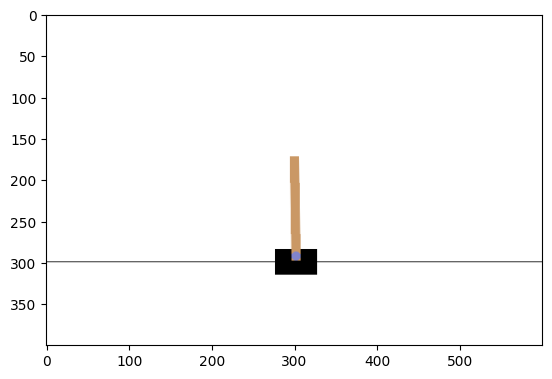

In [80]:
env = gym.make("CartPole-v0").env
env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape

plt.imshow(env.render("rgb_array"))
env.close()

# Approximate Q-learning: building the network

To train a neural network policy one must have a neural network policy. Let's build it.


Since we're working with a pre-extracted features (cart positions, angles and velocities), we don't need a complicated network yet. In fact, let's build something like this for starters:

![img](https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/yet_another_week/_resource/qlearning_scheme.png)

For your first run, please only use linear layers (`nn.Linear`) and activations. Stuff like batch normalization or dropout may ruin everything if used haphazardly. 

Also please avoid using nonlinearities like sigmoid & tanh: since agent's observations are not normalized, sigmoids might be saturated at initialization. Instead, use non-saturating nonlinearities like ReLU.

Ideally you should start small with maybe 1-2 hidden layers with < 200 neurons and then increase network size if agent doesn't beat the target score.

In [81]:
import jax
from typing import Any, Callable, Sequence
from jax import lax, random, numpy as jnp
from flax.core import freeze, unfreeze
from flax import linen as nn


In [82]:
class FlaxModel(nn.Module):
  @nn.compact
  def __call__(self, s):
    s = nn.Dense(128)(s)
    s = nn.relu(s)
    s = nn.Dense(n_actions)(s)
    return s

flax_model = FlaxModel()
# hint: use state_dim[0] as input size

In [83]:
def get_action(state, epsilon=0):
    """
    sample actions with epsilon-greedy policy
    recap: with p = epsilon pick random action, else pick action with highest Q(s,a)
    """

    q_values = flax_model.apply(model_parameters, state)

    action_choice = np.random.rand()
    if action_choice <= epsilon:
      action = np.random.choice(n_actions)
    else:
      action = np.argmax(q_values)

    return int( action )

In [84]:
key = jax.random.PRNGKey(12)
key, param_key = jax.random.split(key, 2)
s = env.reset()
model_parameters = flax_model.init(param_key, s)


[-0.04612203  0.01341587 -0.02232216 -0.03864502]


In [85]:




print(get_action(s)) # "get_action(s) must return int, not %s. try int(action)" % (type(get_action(s)))

# test epsilon-greedy exploration
for eps in [0., 0.1, 0.5, 1.0]:
    state_frequencies = np.bincount(
        [get_action(s, epsilon=eps) for i in range(10000)], minlength=n_actions)
    best_action = state_frequencies.argmax()
    assert abs(state_frequencies[best_action] -
               10000 * (1 - eps + eps / n_actions)) < 200
    for other_action in range(n_actions):
        if other_action != best_action:
            assert abs(state_frequencies[other_action] -
                       10000 * (eps / n_actions)) < 200
    print('e=%.1f tests passed' % eps)

1


KeyboardInterrupt: ignored

### Q-learning via gradient descent

We shall now train our agent's Q-function by minimizing the TD loss:
$$ L = { 1 \over N} \sum_i (Q_{\theta}(s,a) - [r(s,a) + \gamma \cdot max_{a'} Q_{-}(s', a')]) ^2 $$


Where
* $s, a, r, s'$ are current state, action, reward and next state respectively
* $\gamma$ is a discount factor defined two cells above.

The tricky part is with  $Q_{-}(s',a')$. From an engineering standpoint, it's the same as $Q_{\theta}$ - the output of your neural network policy. However, when doing gradient descent, __we won't propagate gradients through it__ to make training more stable (see lectures).

To do so, we shall use `x.detach()` function which basically says "consider this thing constant when doingbackprop".

In [146]:
@jax.jit
def compute_td_loss(model_parameters, states, actions, rewards, next_states, is_done, gamma=0.99, check_shapes=False):
    """ Compute td loss using torch operations only. Use the formula above. """


    states = jnp.array(states)
    actions = jnp.array(actions)
    rewards = jnp.array(rewards)
    next_states = jnp.array(next_states)
    is_done = jnp.array(is_done)

    # get q-values for all actions in current states
    predicted_qvalues = flax_model.apply(model_parameters, states)                               # shape: [batch_size, n_actions]

    # select q-values for chosen actions
    predicted_qvalues_for_actions = jnp.array([predicted_qvalues[i, actions] for i in range(state_dim[0])])

    # compute q-values for all actions in next states
    predicted_next_qvalues = flax_model.apply(model_parameters, next_states)

    # compute V*(next_states) using predicted next q-values
    next_state_values = jnp.max(predicted_next_qvalues)


    # compute "target q-values" for loss - it's what's inside square parentheses in the above formula.
    target_qvalues_for_actions = predicted_qvalues - (jnp.array(rewards) + gamma * next_state_values)

    # at the last state we shall use simplified formula: Q(s,a) = r(s,a) since s' doesn't exist
    target_qvalues_for_actions = jnp.where(
        jnp.array(is_done), jnp.array(rewards), jnp.array(target_qvalues_for_actions))

    # mean squared error loss to minimize
    loss = jnp.mean((predicted_qvalues_for_actions -
                       target_qvalues_for_actions) ** 2)

    return loss

In [147]:
# sanity checks
s = env.reset()
a = env.action_space.sample()
next_s, r, done, _ = env.step(a)
loss = compute_td_loss(model_parameters, [s], [a], [r], [next_s], [done])

print(loss)


0.60515124


### Playing the game

[10 20 33 44]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [148]:


def generate_session(env, t_max=1000, epsilon=0, train=False):
    """play env with approximate q-learning agent and train it at the same time"""
    global opt_state
    global model_parameters
    total_reward = 0
    s = env.reset()
    for t in range(t_max):
        a = get_action(s, epsilon=epsilon)
        next_s, r, done, _ = env.step(a)
        if train:
          loss, loss_grad = jax.value_and_grad(compute_td_loss, argnums = 0)(model_parameters, [s], [a], [r], [next_s], [done])
          updates, opt_state = opt.update(loss_grad, opt_state)
          model_parameters = optax.apply_updates(model_parameters, updates)
        total_reward += r
        s = next_s
        if done:
            break

    return total_reward 

In [149]:
epsilon = 0.5

In [150]:
key = jax.random.PRNGKey(12)
key, param_key = jax.random.split(key, 2)
s = env.reset()
model_parameters = flax_model.init(param_key, s)

opt = optax.adam(1e-4)
opt_state = opt.init(model_parameters)

for i in range(1000):
  session_rewards = []
  for j in range(100):
    total_reward = 0
    s = env.reset()
    for t in range(1000):
      a = get_action(s, epsilon=epsilon)
      next_s, r, done, _ = env.step(a)
      loss, loss_grad = jax.value_and_grad(compute_td_loss, argnums = 0)(model_parameters, [s], [a], [r], [next_s], [done])
      updates, opt_state = opt.update(loss_grad, opt_state)
      model_parameters = optax.apply_updates(model_parameters, updates)
      total_reward += r
      s = next_s
      if done:
        break
    session_rewards.append(total_reward)
  print("epoch #{}\tmean reward = {:.3f}\tepsilon = {:.3f}".format(i, np.mean(session_rewards), epsilon))

  epsilon *= 0.99
  assert epsilon >= 1e-4, "Make sure epsilon is always nonzero during training"

  if np.mean(session_rewards) > 300:
      print("You Win!")
      break

epoch #0	mean reward = 23.850	epsilon = 0.500
epoch #1	mean reward = 22.060	epsilon = 0.495
epoch #2	mean reward = 22.490	epsilon = 0.490
epoch #3	mean reward = 22.740	epsilon = 0.485
epoch #4	mean reward = 22.600	epsilon = 0.480
epoch #5	mean reward = 23.390	epsilon = 0.475
epoch #6	mean reward = 21.030	epsilon = 0.471
epoch #7	mean reward = 22.100	epsilon = 0.466
epoch #8	mean reward = 23.660	epsilon = 0.461
epoch #9	mean reward = 19.300	epsilon = 0.457
epoch #10	mean reward = 21.460	epsilon = 0.452
epoch #11	mean reward = 21.550	epsilon = 0.448
epoch #12	mean reward = 21.230	epsilon = 0.443
epoch #13	mean reward = 20.160	epsilon = 0.439
epoch #14	mean reward = 20.850	epsilon = 0.434
epoch #15	mean reward = 20.710	epsilon = 0.430
epoch #16	mean reward = 19.290	epsilon = 0.426
epoch #17	mean reward = 20.530	epsilon = 0.421
epoch #18	mean reward = 21.140	epsilon = 0.417
epoch #19	mean reward = 18.990	epsilon = 0.413
epoch #20	mean reward = 18.890	epsilon = 0.409
epoch #21	mean reward =

KeyboardInterrupt: ignored

### How to interpret results


Welcome to the f.. world of deep f...n reinforcement learning. Don't expect agent's reward to smoothly go up. Hope for it to go increase eventually. If it deems you worthy.

Seriously though,
* __ mean reward__ is the average reward per game. For a correct implementation it may stay low for some 10 epochs, then start growing while oscilating insanely and converges by ~50-100 steps depending on the network architecture. 
* If it never reaches target score by the end of for loop, try increasing the number of hidden neurons or look at the epsilon.
* __ epsilon__ - agent's willingness to explore. If you see that agent's already at < 0.01 epsilon before it's is at least 200, just reset it back to 0.1 - 0.5.

### Record videos

As usual, we now use `gym.wrappers.Monitor` to record a video of our agent playing the game. Unlike our previous attempts with state binarization, this time we expect our agent to act ~~(or fail)~~ more smoothly since there's no more binarization error at play.

As you already did with tabular q-learning, we set epsilon=0 for final evaluation to prevent agent from exploring himself to death.

In [ ]:
# Record sessions

import gym.wrappers

with gym.wrappers.Monitor(gym.make("CartPole-v0"), directory="videos", force=True) as env_monitor:
    sessions = [generate_session(env_monitor, epsilon=0, train=False) for _ in range(100)]

In [ ]:
# Show video. This may not work in some setups. If it doesn't
# work for you, you can download the videos and view them locally.

from pathlib import Path
from base64 import b64encode
from IPython.display import HTML

video_paths = sorted([s for s in Path('videos').iterdir() if s.suffix == '.mp4'])
video_path = video_paths[-1]  # You can also try other indices

if 'google.colab' in sys.modules:
    # https://stackoverflow.com/a/57378660/1214547
    with video_path.open('rb') as fp:
        mp4 = fp.read()
    data_url = 'data:video/mp4;base64,' + b64encode(mp4).decode()
else:
    data_url = str(video_path)

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(data_url))